### This project focuses on developing a conversational AI for efficient travel planning. It leverages the ["Frames" dataset](https://www.microsoft.com/en-us/research/publication/frames-corpus-adding-memory-goal-oriented-dialogue-systems/), which consists of 1,369 human-human dialogues, totaling 19,986 text entries, specifically designed for goal-oriented dialogues in travel planning contexts like booking flights and hotels.

In [1]:
import pandas as pd
import json

with open('/content/drive/MyDrive/frames.json') as file:
    data = json.load(file)

df = pd.json_normalize(data)

In [ ]:
print(df.shape)
print(df.columns)

(1369, 6)
Index(['user_id', 'turns', 'wizard_id', 'id', 'labels.userSurveyRating',
       'labels.wizardSurveyTaskSuccessful'],
      dtype='object')


In [ ]:
df.head()

,user_id,turns,wizard_id,id,labels.userSurveyRating,labels.wizardSurveyTaskSuccessful
0,U22HTHYNP,[{'text': 'I'd like to book a trip to Atlantis...,U21DKG18C,e2c0fc6c-2134-4891-8353-ef16d8412c9a,4.0,True
1,U21E41CQP,"[{'text': 'Hello, I am looking to book a vacat...",U21DMV0KA,4a3bfa39-2c22-42c8-8694-32b4e34415e9,3.0,True
2,U21RP4FCY,[{'text': 'Hello there i am looking to go on a...,U21E0179B,6e67ed28-e94c-4fab-96b6-68569a92682f,2.0,False
3,U22HTHYNP,[{'text': 'Hi I'd like to go to Caprica from B...,U21DKG18C,5ae76e50-5b48-4166-9f6d-67aaabd7bcaa,5.0,True
4,U21E41CQP,"[{'text': 'Hello, I am looking to book a trip ...",U21DMV0KA,24603086-bb53-431e-a0d8-1dcc63518ba9,5.0,True


In [60]:
turns_df = pd.json_normalize(data, record_path=['turns'])
turns_df.head()

,text,author,timestamp,labels.acts,labels.acts_without_refs,labels.active_frame,labels.frames,db.result,db.search
0,I'd like to book a trip to Atlantis from Capri...,user,1.471272e+12,"[{'args': [{'val': 'book', 'key': 'intent'}], ...","[{'args': [{'val': 'book', 'key': 'intent'}], ...",1,"[{'info': {'intent': [{'val': 'book', 'negated...",NaN,NaN
1,"Hi...I checked a few options for you, and unfo...",wizard,1.471272e+12,"[{'args': [{'val': [{'annotations': [], 'frame...",NaN,1,"[{'info': {'intent': [{'val': 'book', 'negated...",[[{'trip': {'returning': {'duration': {'hours'...,"[{'ORIGIN_CITY': 'Porto Alegre', 'PRICE_MIN': ..."
2,"Yes, how about going to Neverland from Caprica...",user,1.471273e+12,"[{'args': [{'val': 'Neverland', 'key': 'dst_ci...","[{'args': [{'val': 'Neverland', 'key': 'dst_ci...",2,"[{'info': {'intent': [{'val': 'book', 'negated...",NaN,NaN
3,I checked the availability for this date and t...,wizard,1.471273e+12,[{'args': [{'val': [{'annotations': [{'val': N...,NaN,2,"[{'info': {'intent': [{'val': 'book', 'negated...","[[], [], [], [], [], []]","[{'ORIGIN_CITY': 'Caprica', 'PRICE_MIN': '1700..."
4,I have no flexibility for dates... but I can l...,user,1.471273e+12,"[{'args': [{'val': False, 'key': 'flex'}], 'na...","[{'args': [{'val': False, 'key': 'flex'}], 'na...",3,"[{'info': {'intent': [{'val': 'book', 'negated...",NaN,NaN


Total Entries: 19986
Unique Authors: 2
Missing Values:
 text                            0
author                          0
timestamp                       0
labels.acts                     0
labels.acts_without_refs     9579
labels.active_frame             0
labels.frames                   0
db.result                   10407
db.search                   10407
dtype: int64


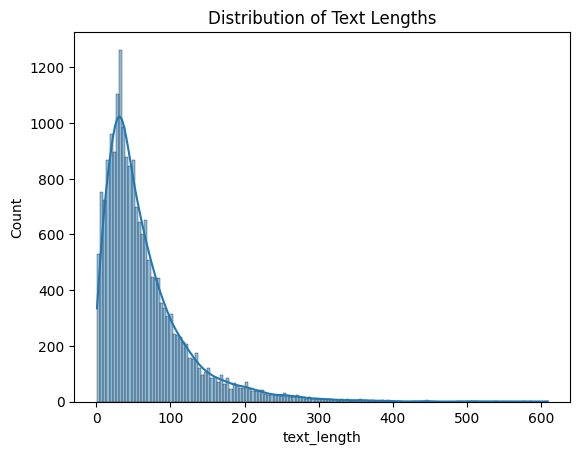

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Counts
print("Total Entries:", turns_df.shape[0])
print("Unique Authors:", turns_df['author'].nunique())
print("Missing Values:\n", turns_df.isnull().sum())

# Text Length Analysis
turns_df['text_length'] = turns_df['text'].apply(len)
sns.histplot(turns_df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.show()

In [3]:
# Creating dialogue pairs
dialog_pairs = []
prev_text = None

for _, row in turns_df.iterrows():
    if row['author'] == 'user':
        prev_text = row['text']
    elif row['author'] == 'wizard' and prev_text is not None:
        dialog_pairs.append((prev_text, row['text']))
        prev_text = None

print(dialog_pairs[:3])

[("I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.", 'Hi...I checked a few options for you, and unfortunately, we do not currently have any trips that meet this criteria.  Would you like to book an alternate travel option?'), ('Yes, how about going to Neverland from Caprica on August 13, 2016 for 5 adults. For this trip, my budget would be 1900.', 'I checked the availability for this date and there were no trips available.  Would you like to select some alternate dates?'), ('I have no flexibility for dates... but I can leave from Atlantis rather than Caprica. How about that?', 'I checked the availability for that date and there were no trips available.  Would you like to select some alternate dates?')]


In [4]:
import torch
from torch.utils.data import Dataset

class MaluubaDataset(Dataset):
    def __init__(self, tokenizer, dialogs, max_length):
        self.tokenizer = tokenizer
        self.inputs = []
        self.attn_masks = []

        for dialog_pair in dialogs:
            # Concatenate user input and wizard response
            dialog_text = dialog_pair[0] + " <|response|> " + dialog_pair[1]

            # Tokenize the concatenated dialog
            encodings = tokenizer(dialog_text, truncation=True, max_length=max_length, padding='max_length')

            self.inputs.append(torch.tensor(encodings['input_ids']))
            self.attn_masks.append(torch.tensor(encodings['attention_mask']))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.attn_masks[idx]

In [7]:
train_pairs = dialog_pairs[:int(len(dialog_pairs)*0.8)]
test_pairs = dialog_pairs[int(len(dialog_pairs)*0.8):]

In [8]:
print(len(train_pairs))
print(len(test_pairs))

7663
1916


### For the fine-tuning task the GPT-2 model was selected due to its advanced language understanding and generation capabilities.

In [9]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

max_length = 512
dataset = MaluubaDataset(tokenizer, train_pairs, max_length)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_function = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
loss_values = []
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
        inputs, masks = batch
        inputs, masks = inputs.to(device), masks.to(device)

        outputs = model(inputs, attention_mask=masks, labels=inputs)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        epoch_loss += loss_value

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)
    print(f"Epoch: {epoch}, Loss: {avg_epoch_loss}")

model.save_pretrained('model')
tokenizer.save_pretrained('model')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Epoch: 0, Loss: 0.23518292797196633
Epoch: 1, Loss: 0.17474715304337365
Epoch: 2, Loss: 0.16169974333869142


('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.json',
 'model/merges.txt',
 'model/added_tokens.json')

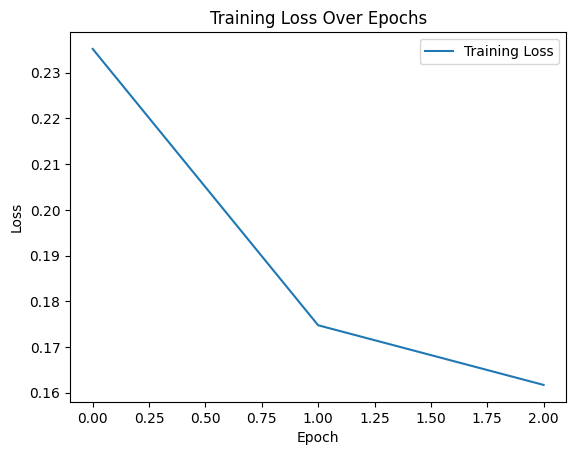

In [12]:
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [8]:
# Checking the size of the model
sum(p.numel() for p in model.parameters())

124439808

In [28]:
model_path = 'model'
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

def generate_text(prompt, length=50):
    model.eval()

    tokenizer.padding_side = "left"

    inputs = tokenizer.encode_plus(prompt, return_tensors='pt', add_special_tokens=True, max_length=length, padding='max_length', truncation=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    generated_length = length + 50
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=generated_length, num_return_sequences=1, no_repeat_ngram_size=2, pad_token_id=50256)

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [58]:
prompt_text = "Hi! My best friend and I want to go on vacation to Porto Alegre."
generate_text(prompt_text, length=100)

'Hi! My best friend and I want to go on vacation to Porto Alegre. <|response|> Ok! Where will you be leaving from?'

In [ ]:
generated_texts = []
real_answers = []
for dialog in test_pairs:
  real_answers.append(dialog[1])
  generated_texts.append(generate_text(dialog[0], length=100).split('<|response|>')[1].strip())

### For evaluating the model's performance, metrics such as Perplexity, BLEU score, and ROUGE-1 score were implemented.

In [13]:
model = GPT2LMHeadModel.from_pretrained('model')
tokenizer = GPT2Tokenizer.from_pretrained('model')
tokenizer.pad_token = tokenizer.eos_token

max_length = 512
test_dataset = MaluubaDataset(tokenizer, test_pairs, max_length)
test_loader = DataLoader(test_dataset, batch_size=4)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total_loss = 0
total_items = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, masks = batch
        inputs, masks = inputs.to(device), masks.to(device)

        outputs = model(inputs, attention_mask=masks, labels=inputs)
        loss = outputs.loss.item()

        total_loss += loss * inputs.size(0)
        total_items += inputs.size(0)

perplexity = torch.exp(torch.tensor(total_loss / total_items))
print(f"Perplexity: {perplexity}")

Perplexity: 1.1690614223480225


In [51]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import numpy as np

def calculate_bleu_score(references, candidates):
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        ref_tokenized = [word_tokenize(ref.lower())]
        cand_tokenized = word_tokenize(cand.lower())
        score = sentence_bleu(ref_tokenized, cand_tokenized)
        bleu_scores.append(score)
    return np.mean(bleu_scores)

def calculate_accuracy(references, candidates):
    correct_predictions = sum([1 for ref, cand in zip(references, candidates) if ref == cand])
    total_predictions = len(references)
    return correct_predictions / total_predictions

bleu_score = calculate_bleu_score(real_answers, generated_texts)
accuracy = calculate_accuracy(real_answers, generated_texts)

print(f"BLEU Score: {bleu_score}")
print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.00883845742792353
Accuracy: 0.0


In [54]:
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu_score(references, candidates):
    smoothie = SmoothingFunction().method1
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        ref_tokenized = [word_tokenize(ref.lower())]
        cand_tokenized = word_tokenize(cand.lower())
        score = sentence_bleu(ref_tokenized, cand_tokenized, smoothing_function=smoothie)
        bleu_scores.append(score)
    return np.mean(bleu_scores)

In [55]:
bleu_score_smoothing = calculate_bleu_score(real_answers, generated_texts)

print(f"BLEU Score: {bleu_score_smoothing}")

BLEU Score: 0.02261249392230394


In [53]:
from rouge import Rouge

def calculate_rouge_score(references, candidates):
    rouge = Rouge()
    scores = rouge.get_scores(candidates, references, avg=True)
    return scores['rouge-1']['f']

rouge_1_score = calculate_rouge_score(real_answers, generated_texts)
print(f"ROUGE-1 Score: {rouge_1_score}")

ROUGE-1 Score: 0.14014269644380106


#### The project's results using a fine-tuned GPT-2 model for conversational AI in travel planning yielded mixed outcomes. The Perplexity score of 1.169 indicates a high predictive accuracy, yet the BLEU Score, at 0.0088 (0.0226 with smoothing), and an Accuracy of 0.0 suggest challenges in generating text closely matching the reference responses. The ROUGE-1 Score of 0.140 shows a moderate level of unigram overlap with the reference texts, reflecting the model's ability to capture some key content aspects. These results highlight areas for further model refinement and adjustment.